# Google trends data exploration

In [8]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [9]:
pytrends = TrendReq(hl='en-US', tz=360)

### Setup a payload for 'Gas prices' in the US 

In [10]:
keyword = "Gas prices"
kw_list = [keyword]
pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='US', gprop='')

In [11]:
# Get the gasoline interest dataframe.
interest_df = pytrends.interest_over_time()
interest_df.head()

# TODO: List some major economic events in the U.S.
# Can even look at data by state - geo = 'US-WA' for example. can do a map visualization over time of state relative queries.

,Gas prices,isPartial
date,,
2004-01-01,5,False
2004-02-01,6,False
2004-03-01,11,False
2004-04-01,13,False
2004-05-01,31,False


#### What do the numbers represent?
From google trends: "Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."

### Check for null entries

In [12]:
has_null = any(interest_df[keyword].isnull())
if has_null:
    print("Null entries found... removing null entries")
    interest_df = interest_df.dropna()
    has_null = any(interest_df['Gas prices'].isnull())
    
assert not has_null

### Check that there is consistent time granularity between rows

In [13]:
for i in range(interest_df.shape[0] - 1):
    entry_time_difference = interest_df.index[i + 1] - interest_df.index[i]
    x = list(entry_time_difference.components)
    assert sum(x) == max(x)

# A sample difference in time between rows.
print("Time granularity is approximately:", entry_time_difference)

Time granularity is approximately: 30 days 00:00:00


### Describe data

In [14]:
interest_df.describe()

,Gas prices
count,185.000000
mean,13.827027
std,11.388511
min,5.000000
25%,8.000000
50%,10.000000
75%,15.000000
max,100.000000


### Trend visualization for keywords

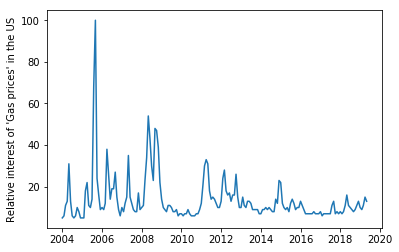

In [15]:
for k_word in interest_df.columns:
    if k_word == 'isPartial':
        continue
        
    plt.plot(interest_df.index, interest_df[k_word])
    plt.ylabel("Relative interest of \'{}\' in the US".format(k_word))
    plt.show()

## Sample ARIMA model fitting on data

In [16]:
# TODO: Check conditions for ARIMA modelling

### Autocorrelation plot

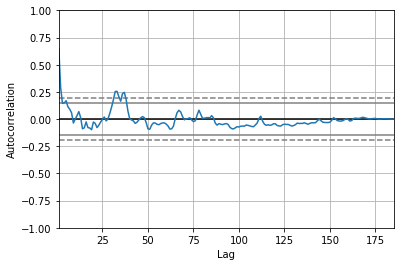

In [17]:
autocorrelation_plot(interest_df[keyword])

In [29]:

model = ARIMA(interest_df[keyword], order=(7,1,0), dates=interest_df.index)
model_fit = model.fit()
#print(model_fit.summary())

/Users/arvinds/anaconda3/envs/future_gas/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/arvinds/anaconda3/envs/future_gas/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### Fitted ARIMA model

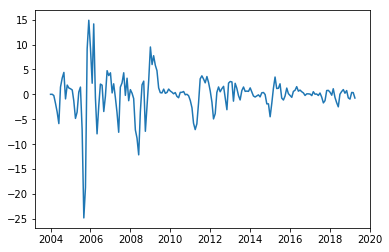

In [30]:
plt.plot(interest_df.index[:-1], model_fit.fittedvalues)

### Residuals of model vs. real data

                0
count  184.000000
mean     0.043106
std      8.667875
min    -51.209124
25%     -2.318697
50%     -0.515718
75%      1.621157
max     52.536320


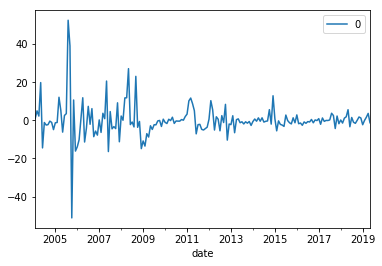

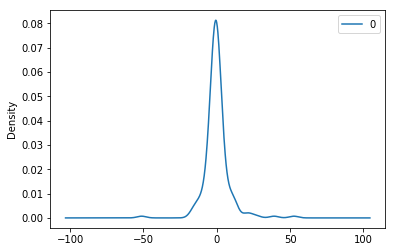

In [31]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

### Using related queries as feedback to get more results

In [70]:
related = pytrends.related_queries()

In [76]:
related['Gas prices']

{'top':                     query  value
 0               gas price    100
 1      gas prices near me     97
 2      natural gas prices     90
 3             natural gas     86
 4              oil prices     70
 5       costco gas prices     54
 6              costco gas     54
 7      average gas prices     46
 8         gas prices ohio     43
 9               cheap gas     43
 10       cheap gas prices     43
 11            gas station     40
 12     gas station prices     39
 13  gas prices california     34
 14          us gas prices     32
 15        high gas prices     31
 16        best gas prices     31
 17      lowest gas prices     31
 18    cheapest gas prices     29
 19           cheapest gas     29
 20     current gas prices     28
 21          ca gas prices     28
 22       state gas prices     25
 23       texas gas prices     23
 24    michigan gas prices     22,
 'rising':                           query   value
 0            gas prices near me  534700
 1              